In [1]:
import numpy as np
import pandas as pd
import pickle
#import matplotlib.pyplot as plt
#import seaborn as sns
import pathlib
import sys
import warnings
import imp

from os import walk, chdir, getcwd
from datetime import datetime
#from scipy.stats import iqr, wilcoxon, normaltest, sem, t
#from arch.bootstrap import IIDBootstrap
from mymodule import viz, metrics


#sns.set_style('dark')
warnings.filterwarnings('ignore')

In [2]:
# this is all drugcomb's data used to normalize by
with open('/tf/notebooks/code_for_pub/input_files/synergy_sens_averaged_by_blockID_replicates', 'rb') as f:
    metrics_df = pickle.load(f)

In [3]:
imp.reload(viz)

<module 'mymodule.viz' from '/tf/notebooks/code_for_pub/mymodule/viz.py'>

### no reps model


In [10]:
working_dir = '/tf/notebooks/code_for_pub/_logs_as_python_files'

# change dir
chdir(working_dir)

# list files
files = next(walk(getcwd()))[2]
files = [x for x in files if ('csv' not in x) & ('0.1' not in x)]

# get month when the files was created. We need the ones from december
time_of_change = dict()
for x in files:
    mtime = pathlib.Path(x).stat()
    time_of_change[x] = datetime.fromtimestamp(mtime.st_mtime).month
    
# pick those created in december & not hungabunga one
files = sorted([x for x in time_of_change.keys() if \
                #(time_of_change[x] == 12) &\
                ('hunga' not in x)\
                &('withreplicatesRFonly' not in x) &\
                ('14models_' not in x) & \
                ('Dec 15 20:46:24' not in x) &\
                ('noreplicates' in x) &\
                ('fps_transformer_1024bit_04_noreplicates_Wed Dec 16 07:58:05 2020.pickle' not in x) &\
                ('fps_transformer_256bit_04_noreplicates_Tue Dec 15 16:04:14 2020.pickle' not in x) &\
                ('fps_vae_16bit_04_noreplicates_Wed Dec 16 13:27:08 2020.pickle' not in x) &\
                ('Transformer64_new_noreplicates_0.4_Sun Dec 27 16:30:31 2020.pickle' not in x) &\
                ('fps_gae_64bit_04_noreplicates_Tue Dec 15 06:52:50 2020.pickle' not in x) &\
                ('fps_gae_16bit_04_noreplicates_Wed Dec 16 10:38:43 2020.pickle' not in x) &\
                ('fps_VAE_256bit_04_noreplicates_Mon Dec 14 12:12:01 2020.pickle' not in x)
               ]) 

In [12]:
files.pop(0)
files.pop(1)
files.pop(1)

'GAE48to64_new_noreplicates_0.4_Wed Dec 30 11_59_19 2020.pickle'

In [13]:
files

['GAE16to32_new_noreplicates_0.4_Wed Dec 30 16_47_53 2020.pickle',
 'GAE64_new_noreplicates_0.4_Mon Dec 28 23:41:21 2020.pickle',
 'Transformer1024_new_noreplicates_0.4_Mon Dec 28 06:53:13 2020.pickle',
 'Transformer64_new_noreplicates_0.4_Tue Dec 29 06:54:37 2020.pickle',
 'VAE16_new_noreplicates_0.4_Tue Dec 29 10:40:36 2020.pickle',
 'VAE256_new_noreplicates_0.4_Wed Dec 30 04:45:20 2020.pickle',
 'fps_e3fp_1024bit_04_noreplicates_Mon Dec 14 18:06:31 2020.pickle',
 'fps_infomax_04_noreplicates_Mon Dec 14 04:18:32 2020.pickle',
 'fps_morgan_1024bit_04_noreplicates_Tue Dec 15 09:59:17 2020.pickle',
 'fps_morgan_300bit_04_noreplicates_Wed Dec 16 19:37:12 2020.pickle',
 'fps_topo_1024bit_04_CORRECTdtype_noreplicates_Sun Dec 20 00:53:09 2020.pickle']

In [14]:
# load 
full_log = dict()
for x in files:
    filename = '/tf/notebooks/code_for_pub/_logs_as_python_files/' + x
    with open(filename, 'rb') as f:
        log_file = pickle.load(f)
        if x.startswith('fps'):
            correct_name = x[4:x.find('04')-1].lower()
        else: 
            correct_name = x.split('_')[0]
        full_log[correct_name] = log_file
full_log = dict(sorted(full_log.items()))

In [15]:
normalizer_dict = metrics.make_normalizer(metrics_df)

In [16]:

# testing bootstrap
val = [0.6419948276850342,
 0.6474037244893786,
 0.6345210885840264,
 0.641972630080717,
 0.6291225414293318,
 0.6398652529199027,
 0.6447215815688255,
 0.6359724325141045,
 0.6444897470665087,
 0.6336721495944178]



a1, a2 = metrics.mean_confidence_interval_normed(val, 
                                         metric='synergy_loewe', 
                                         norm='none',
                                         test_type='bs',
                                         bootstrap_reps=1000,
                                         normalizer=normalizer_dict, 
                                         confidence=0.95)
print(a1,a2)


0.6394 0.0057


In [17]:
full_log.keys()

dict_keys(['GAE16to32', 'GAE64', 'Transformer1024', 'Transformer64', 'VAE16', 'VAE256', 'e3fp_1024bit', 'infomax', 'morgan_1024bit', 'morgan_300bit', 'topo_1024bit'])

In [18]:
# '16','16',
length = ['16','64',
          '1024','64',
          '16','256',
          '1024',
          '300',
          '1024','300',
          '1024']

val_fraction = [0.4]*len(full_log.keys())

# 'GAE0to16','GAE16to32',
index = [['GAE16','GAE64', 
          'T', 'T',
          'VAE','VAE',
          'E3FP',
          'Infomax',
          'Morgan','Morgan', 
          'Topo'], \
         [16,16,
         1024,64,
         16,256,
         1024,
         300,
         1024, 300,
         1024],val_fraction]

#https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html

In [19]:
# t-dist
css_ci95, zip_ci95, loewe_ci95, bliss_ci95, hsa_ci95 = \
metrics.make_confidence_data(test_type='t',
                             log_file=full_log,
                             normalizer_dict=normalizer_dict)

holder_T, holder_melt_T = viz.make_plot_data(c=css_ci95,
                                                 z=zip_ci95,
                                                 l=loewe_ci95,
                                                 b=bliss_ci95,
                                                 h=hsa_ci95,
                                                 index=index)

In [20]:
# z-transform
css_ci95, zip_ci95, loewe_ci95, bliss_ci95, hsa_ci95 = \
metrics.make_confidence_data(test_type='z',
                             log_file=full_log,
                             normalizer_dict=normalizer_dict)

holder_Z, holder_melt_Z = viz.make_plot_data(c=css_ci95,
                                                 z=zip_ci95,
                                                 l=loewe_ci95,
                                                 b=bliss_ci95,
                                                 h=hsa_ci95,
                                                 index=index)

In [21]:
# symmetrical bootstrap
css_ci95, zip_ci95, loewe_ci95, bliss_ci95, hsa_ci95 = \
metrics.make_confidence_data(test_type='own',
                             log_file=full_log,
                             bootstrap_reps=1000,
                             normalizer_dict=normalizer_dict)

holder_Sym, holder_melt_Sym = viz.make_plot_data(c=css_ci95,
                                                 z=zip_ci95,
                                                 l=loewe_ci95,
                                                 b=bliss_ci95,
                                                 h=hsa_ci95,
                                                 index=index)

In [22]:
# bootstrap BCa
css_ci95, zip_ci95, loewe_ci95, bliss_ci95, hsa_ci95 = \
metrics.make_confidence_data(test_type='bs',
                             log_file=full_log,
                             bootstrap_reps=1000,
                             normalizer_dict=normalizer_dict)

holder_B, holder_melt_B = viz.make_plot_data(c=css_ci95,
                                             z=zip_ci95,
                                             l=loewe_ci95,
                                             b=bliss_ci95,
                                             h=hsa_ci95,
                                             index=index)

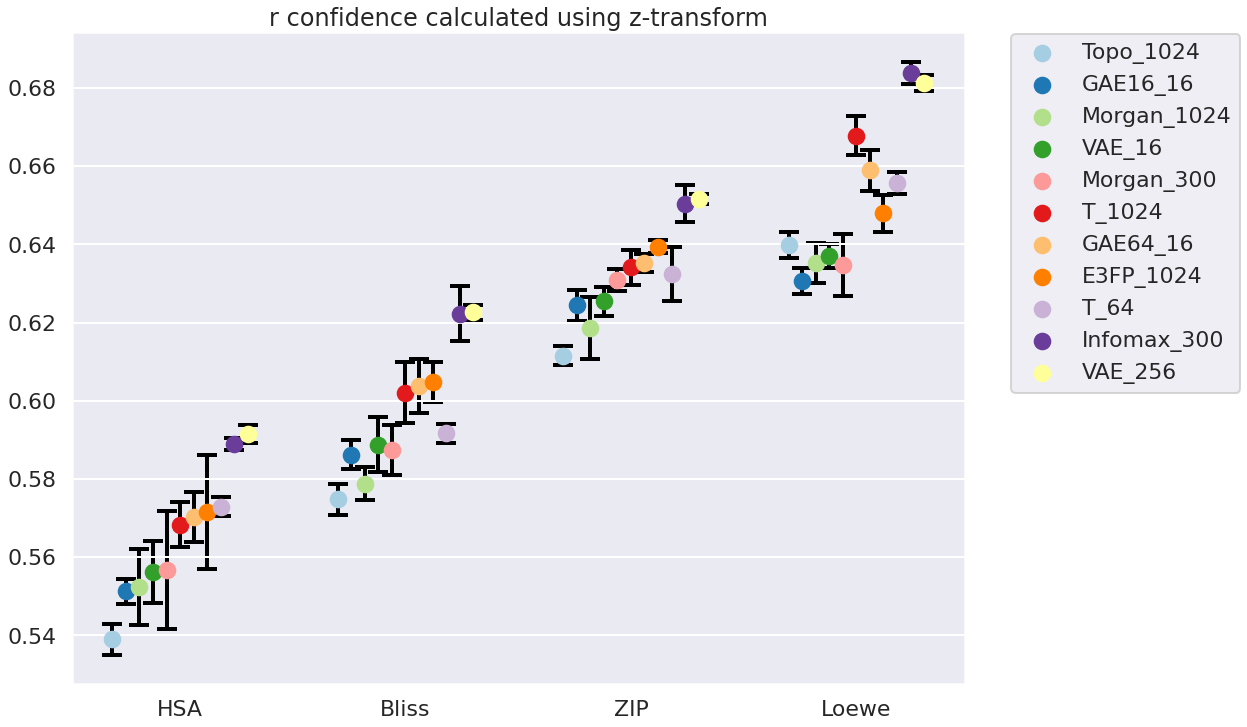

In [25]:
viz.space_invaders(name_plot='r',
                   ci='z-transform',
                   holder_melt=holder_melt_Z,
                   include_css=False)\
.show()

In [36]:
viz.colors(name='no_norm',holder = holder_Z) # no_norm's CI do not work

In [3]:
# normaltest
#for x1,x2 in zip([css, zip_s, loewe, hsa, bliss],['css', 'zip_s', 'loewe', 'hsa', 'bliss']):
#    print(x2)
#    for k,v in x1.items():
#        n1 = round(normaltest( [x[0][0] for x in v[0] ])[1], 4)
#        n2 = round(normaltest( [x[1] for x in v[0] ])[1], 4)
#        if (n1 < 0.05) | (n2 < 0.05):
#            print(f'{k}. r {n1}, rmse {n2}')
#    print('\n')

In [4]:
#for k,v in zip_s.items():
#    a = np.array([x[0][0] for x in v[0] ])
#    break
# a1, a2 = IIDBootstrap(a).conf_int(scipy.stats.sem, 5000, method='bca')
# scipy.stats.sem(a)* scipy.stats.t.ppf((1 + 0.95) / 2, 10-1) # t version
# float((a1+a2)/2)* scipy.stats.t.ppf((1 + 0.95) / 2, 10-1) # bs

In [75]:
df = colors('sd', ci='bs').data.copy()
df.colums = df.columns
df = df.droplevel(axis=1,level=1)
df = df.iloc[:11,:]
df.reset_index(inplace=True)
df.columns = ['fp', 'size', 'fraction_test', 'CSS_RI', 'ci95_css',
             'ZIP','ci95_zip',
              'Loewe','ci95_loewe',
              'Bliss','ci95_bliss',
              'HSA','ci95_hsa',
             ]


In [76]:
print(df.to_latex(index=False,bold_rows=True,longtable=True))

\begin{longtable}{lllrrrrrrrrrr}
\toprule
          fp &  size & fraction\_test &  CSS\_RI &  ci95\_css &     ZIP &  ci95\_zip &   Loewe &  ci95\_loewe &   Bliss &  ci95\_bliss &     HSA &  ci95\_hsa \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
        e3fp &  1024 &           0.4 &  0.5034 &    0.0007 &  0.7715 &    0.0057 &  0.7624 &      0.0019 &  0.7987 &      0.0040 &  0.8214 &    0.0031 \\
         GAE &    16 &           0.4 &  0.5254 &    0.0015 &  0.7932 &    0.0071 &  0.7993 &      0.0028 &  0.8247 &      0.0073 &  0.8483 &    0.0042 \\
         GAE &    64 &           0.4 &  0.5031 &    0.0010 &  0.7780 &    0.0058 &  0.7600 &      0.0021 &  0.8036 &      0.0061 &  0.8249 &    0.0031 \\
     Infomax &   300 &           0.4 &  0.4825 &    0.0008 &  0.7621 &    0.0062 &  0.7287 &      0.0019 &  0.7850 &      0.0039 &  0.8085 &    0.0034 \\
      Morgan &  1024 &           0.4 &  0.5204 &    0.0005 & 

In [5]:
def make_normalizer(df):
    
    normalizer = dict()
    normalizer['sd'] = dict(df.std(axis='index')) # get st.dev
    normalizer['iqr'] = dict(zip(normalizer['sd'].keys(), iqr(df, axis=0))) # get iqr
    normalizer['range'] = dict()
    for x in normalizer['sd'].keys(): # get range
        r = df[x].max() + abs(df[x].min())
        normalizer['range'][x] = r
    return normalizer


In [6]:
# calculate 95% CI using student t-distribution
# standardize rmse either by IQ25-75 or st.dev or range or none


def mean_confidence_interval_normed(data, metric, normalizer,bootstrap_reps=1000, norm='none', test_type='bs', confidence=0.95): 
    '''
    norm can be st or iqr or range or none. 
    test_type either bs or t
    Normalizer should have all the data
    https://arch.readthedocs.io/en/latest/bootstrap/generated/generated/arch.bootstrap.IIDBootstrap.conf_int.html#arch.bootstrap.IIDBootstrap.conf_int
    '''
    if metric in ['css_ri', 'synergy_zip', 'synergy_bliss', 'synergy_hsa', 'synergy_loewe']:
        if norm in ['sd','iqr','range']:
            a = np.array(data)/normalizer[norm][metric]
            mean_val = np.mean(a)
        elif norm=='none':
            a = np.array(data)
            mean_val = np.mean(a)
        else:
            print('no norming info!')
            return
    if test_type == 't': # standard t-dist
        ci = _mean_confidence_interval(data=a, confidence=confidence)
    elif test_type == 'bs': # 
        # the idea is that we take mean to be as is, but we take its 95% CI bootstrapped
        n = len(a)
        # batch-correct and accelerated bootstrap. For now it defaults to 0.95. Fix by using partial 
        ci = IIDBootstrap(a).conf_int(_mean_confidence_interval, 
                                      reps=bootstrap_reps, 
                                      method='bca')
        ci = ci[1]
        mean_val = np.mean(a)
    return round(mean_val, 4), round(float(ci), 4) # return upper bound

def _mean_confidence_interval(data=None, confidence=0.95):
    assert data is not None
    a = np.array(data)
    n = len(a)
    se = sem(a)
    h = se * t.ppf((1 + confidence) / 2, n-1)
    return h

In [7]:
def make_confidence_data(test_type=None, log_file=None, normalizer_dict=None):
    '''
    test type is t or bs
    log_file should have data read from teh disk
    normalizer dict should have drugcomb-wide vals with iqr,range,sd
    '''
    css={}
    zip_s={}
    loewe={}
    hsa={}
    bliss = {}
    for k,v in log_file.items():
        for kk,vv in v.items():
            if 'name' != kk:
                if kk == 'css_ri':
                    css[k] = vv
                elif kk == 'synergy_zip':
                    zip_s[k] = vv
                elif kk == 'synergy_bliss':
                    bliss[k] = vv
                elif kk == 'synergy_loewe':
                    loewe[k] = vv
                elif kk == 'synergy_hsa':
                    hsa[k] =vv
    # pearson r's
    css_ci95={}
    zip_ci95={}
    loewe_ci95={}
    hsa_ci95={}
    bliss_ci95 ={} # use defaultdict instead
    css_ci95['r'] = dict()
    zip_ci95['r'] = dict() 
    loewe_ci95['r'] = dict()
    hsa_ci95['r'] = dict() 
    bliss_ci95['r'] = dict() 

    for k,v in css.items():
        css_ci95['r'][k] = mean_confidence_interval_normed(data=[x[0][0] for x in v[0] ], 
                                                           metric='css_ri',
                                                           normalizer=normalizer_dict,
                                                           test_type = test_type,
                                                           norm='none')
    for k,v in zip_s.items():
        zip_ci95['r'][k] = mean_confidence_interval_normed(data=[x[0][0] for x in v[0] ], 
                                                           metric='synergy_zip',
                                                           normalizer=normalizer_dict,
                                                           test_type = test_type, 
                                                           norm='none' )
    for k,v in loewe.items():
        loewe_ci95['r'][k] = mean_confidence_interval_normed(data=[x[0][0] for x in v[0] ], 
                                                             metric='synergy_loewe',
                                                             normalizer=normalizer_dict,
                                                             test_type = test_type, 
                                                             norm='none' )
    for k,v in bliss.items():
        bliss_ci95['r'][k] = mean_confidence_interval_normed(data=[x[0][0] for x in v[0] ], 
                                                             metric='synergy_bliss',
                                                             normalizer=normalizer_dict,
                                                             test_type = test_type, 
                                                             norm='none' )
    for k,v in hsa.items():
        hsa_ci95['r'][k] = mean_confidence_interval_normed(data=[x[0][0] for x in v[0] ], 
                                                           metric='synergy_hsa',
                                                           normalizer=normalizer_dict,
                                                           test_type = test_type, 
                                                           norm='none' )

    # add rmse's normed by st.dev
    css_ci95['sd'] = dict()
    zip_ci95['sd'] = dict() 
    loewe_ci95['sd'] = dict()
    hsa_ci95['sd'] = dict() 
    bliss_ci95['sd'] = dict() 

    for k,v in css.items():
        css_ci95['sd'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                            metric='css_ri',
                                                            normalizer=normalizer_dict,
                                                            test_type = test_type, 
                                                            norm='sd' )
    for k,v in zip_s.items():
        zip_ci95['sd'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                            metric='synergy_zip',
                                                            normalizer=normalizer_dict,
                                                            test_type = test_type, 
                                                            norm='sd' )
    for k,v in loewe.items():
        loewe_ci95['sd'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                              metric='synergy_loewe',
                                                              normalizer=normalizer_dict,
                                                              test_type = test_type, 
                                                              norm='sd' )
    for k,v in bliss.items():
        bliss_ci95['sd'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                              metric='synergy_bliss',
                                                              normalizer=normalizer_dict,
                                                              test_type = test_type, 
                                                              norm='sd' )
    for k,v in hsa.items():
        hsa_ci95['sd'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                            metric='synergy_hsa',
                                                            normalizer=normalizer_dict,
                                                            test_type = test_type, 
                                                            norm='sd')

    # add rmse's normed by st.dev
    css_ci95['iqr'] = dict()
    zip_ci95['iqr'] = dict() 
    loewe_ci95['iqr'] = dict()
    hsa_ci95['iqr'] = dict() 
    bliss_ci95['iqr'] = dict() 

    for k,v in css.items():
        css_ci95['iqr'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                             metric='css_ri',
                                                             normalizer=normalizer_dict,
                                                             test_type = test_type, 
                                                             norm='iqr' )
    for k,v in zip_s.items():
        zip_ci95['iqr'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                             metric='synergy_zip',
                                                             normalizer=normalizer_dict,
                                                             test_type = test_type, 
                                                             norm='iqr' )
    for k,v in loewe.items():
        loewe_ci95['iqr'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                               metric='synergy_loewe',
                                                               normalizer=normalizer_dict,
                                                               test_type = test_type, 
                                                               norm='iqr' )
    for k,v in bliss.items():
        bliss_ci95['iqr'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                               metric='synergy_bliss',
                                                               normalizer=normalizer_dict,
                                                               test_type = test_type, 
                                                               norm='iqr' )
    for k,v in hsa.items():
        hsa_ci95['iqr'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                             metric='synergy_hsa',
                                                             normalizer=normalizer_dict,
                                                             test_type = test_type, 
                                                             norm='iqr')

    # normed by range
    css_ci95['range'] = dict()
    zip_ci95['range'] = dict() 
    loewe_ci95['range'] = dict()
    hsa_ci95['range'] = dict() 
    bliss_ci95['range'] = dict() 

    for k,v in css.items():
        css_ci95['range'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                               metric='css_ri',
                                                               normalizer=normalizer_dict,
                                                               test_type = test_type, 
                                                               norm='range' )
    for k,v in zip_s.items():
        zip_ci95['range'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                               metric='synergy_zip',
                                                               normalizer=normalizer_dict,
                                                               test_type = test_type, 
                                                               norm='range' )
    for k,v in loewe.items():
        loewe_ci95['range'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                                 metric='synergy_loewe',
                                                                 normalizer=normalizer_dict,
                                                                 test_type = test_type, 
                                                                 norm='range' )

    for k,v in bliss.items():
        bliss_ci95['range'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                                 metric='synergy_bliss',
                                                                 normalizer=normalizer_dict,
                                                                 test_type = test_type, 
                                                                 norm='range' )

    for k,v in hsa.items():
        hsa_ci95['range'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                               metric='synergy_hsa',
                                                               normalizer=normalizer_dict,
                                                               test_type = test_type, 
                                                               norm='range') 
    # normed by range
    css_ci95['no_norm'] = dict()
    zip_ci95['no_norm'] = dict() 
    loewe_ci95['no_norm'] = dict()
    hsa_ci95['no_norm'] = dict() 
    bliss_ci95['no_norm'] = dict() 

    for k,v in css.items():
        css_ci95['no_norm'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                                 metric='css_ri',
                                                                 normalizer=normalizer_dict,
                                                                 test_type = test_type, 
                                                                 norm='none' )
    for k,v in zip_s.items():
        zip_ci95['no_norm'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ],
                                                                 metric='synergy_zip',
                                                                 normalizer=normalizer_dict,
                                                                 test_type = test_type, 
                                                                 norm='none' )
    for k,v in loewe.items():
        loewe_ci95['no_norm'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ],
                                                                   metric='synergy_loewe',
                                                                   normalizer=normalizer_dict,
                                                                   norm='none' ,
                                                                   test_type = test_type)
    for k,v in bliss.items():
        bliss_ci95['no_norm'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ],
                                                                   metric='synergy_bliss',
                                                                   normalizer=normalizer_dict,
                                                                   norm='none',
                                                                   test_type = test_type )
    for k,v in hsa.items():
        hsa_ci95['no_norm'][k] = mean_confidence_interval_normed(data=[x[1] for x in v[0] ], 
                                                                 metric='synergy_hsa', 
                                                                 normalizer=normalizer_dict,
                                                                 norm='none',
                                                                 test_type = test_type) 
    return css_ci95,zip_ci95,loewe_ci95,bliss_ci95,hsa_ci95

In [129]:
working_dir = '/tf/notebooks/code_for_pub'

# change dir
chdir(working_dir)
colors('r', ci='t').data.to_csv('prediction_results_deduped_r_t.csv')
colors('r', ci='t').data.to_csv('prediction_results_deduped_r_t.csv')
colors('r', ci='bs').data.to_csv('prediction_results_deduped_r_bs.csv')
colors('sd', ci='t').data.to_csv('prediction_results_deduped_rmse_sd_t.csv')
colors('sd', ci='bs').data.to_csv('prediction_results_deduped_rmse_sd_bs.csv')
colors('no_norm', ci='t').data.to_csv('prediction_results_deduped_no_norm_sd_t.csv')
colors('no_norm', ci='bs').data.to_csv('prediction_results_deduped_no_norm_sd_bs.csv')
colors('r', ci='t').data.to_csv('prediction_results_deduped_r_t.csv')

colors('range', ci='t').data.to_csv('prediction_results_deduped_rmse_range_t.csv')
colors('range', ci='bs').data.to_csv('prediction_results_deduped_rmse_range_bs.csv')
colors('iqr', ci='t').data.to_csv('prediction_results_deduped_rmse_iqr_t.csv')
colors('iqr', ci='bs').data.to_csv('prediction_results_deduped_rmse_iqr_bs.csv')

working_dir = '/tf/notebooks/code_for_pub/_logs_as_python_files'
chdir(working_dir)


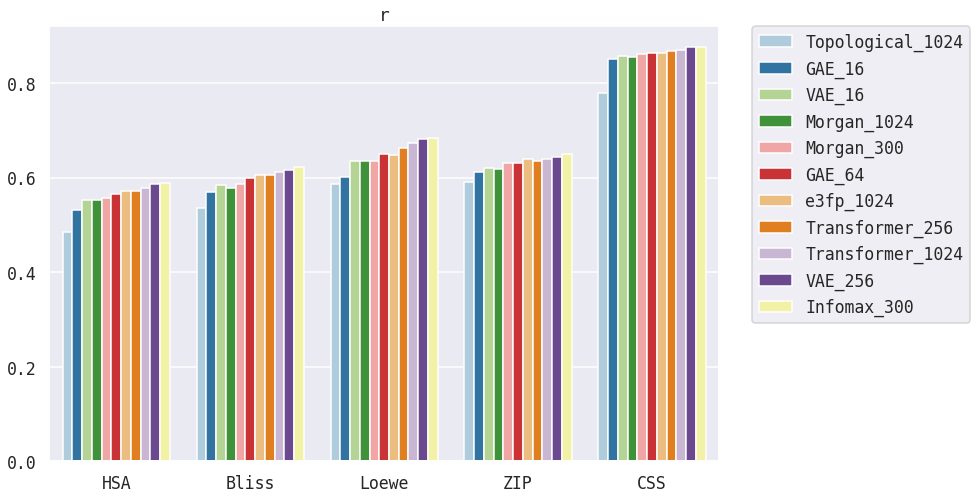

In [30]:
name_plot = 'r'
name_y = 'rmse_'+name_plot

if name_plot == 'r':
    name_y = 'mean_corr'

sns.set_theme(style='darkgrid', context='talk', font='monospace', color_codes=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 0.1

ax = sns.barplot(x='metric', y=name_y, hue='model', data=holder_melt[name_plot], dodge=0.2, ci=None, 
                 palette=sns.color_palette("Paired")
)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

ax.set_xlabel('')
ax.set_ylabel('')
plt.title('normed by '+name_plot)

if name_plot == 'r':
    plt.title('r')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [33]:
working_dir = '/tf/notebooks/code_for_pub/_logs_as_python_files'

# change dir
chdir(working_dir)

# list files
files = next(walk(getcwd()))[2]

# get month when the files was created. We need the ones from december
time_of_change = dict()
for x in files:
    mtime = pathlib.Path(x).stat()
    time_of_change[x] = datetime.fromtimestamp(mtime.st_mtime).month
    
# pick those created in december & not hungabunga one
files = sorted([x for x in time_of_change.keys() if \
 (time_of_change[x] != 12) & \
 ('hunga' not in x) & \
 ('withreplicatesRFonly' not in x) ])

In [34]:
# load 
full_log = dict()
for x in files:
    filename = '/tf/notebooks/code_for_pub/_logs_as_python_files/' + x
    with open(filename, 'rb') as f:
        log_file = pickle.load(f)
        correct_name = x[4:x.find('04')+2].lower()
        full_log[correct_name] = log_file
full_log = dict(sorted(full_log.items()))

In [35]:
 # use lr015 for morgan fps and not original 0.2 and 5000 its
files = sorted([x for x in files if x not in ['fps_morgan_1024bit_0.4valid.pickle', 'fps_morgan_1024bit_0.1valid.pickle']])

In [36]:
a = dict()
for x in files:
    n = '/tf/notebooks/code_for_pub/_logs_as_python_files/' + x
    if 'fps' in x:
        with open(n, 'rb') as f:
            sc = pickle.load(f)
            a[x] = sc



In [38]:
myorder = sorted(list(a.keys()))

In [178]:
#myorder = ['fps_gae_16bit_SVD_0.1valid.pickle','fps_gae_16bit_SVD_0.4valid.pickle',
#           'fps_gae_64bit_0.1valid.pickle','fps_gae_64bit_0.4valid.pickle',
#           'fps_infomax_300bit_0.1valid.pickle','fps_infomax_300bit_0.4valid.pickle',
#           'fps_transformer_256bit_0to256_0.1valid.pickle','fps_transformer_256bit_0to256_0.4valid.pickle',
#           'fps_transformer_1024bit_0.1valid.pickle','fps_transformer_1024bit_0.4valid.pickle',
#           'fps_vae_16bit_0.1valid.pickle','fps_vae_16bit_0.4valid.pickle',\
#           'fps_vae_256bit_0.1valid.pickle','fps_vae_256bit_0.4valid.pickle',
#           'fps_e3fp_1024bit_0.1valid.pickle','fps_e3fp_1024bit_0.4valid.pickle',
#           #'fps_morgan_300bit_0.1valid.pickle','fps_morgan_300bit_0.4valid.pickle',\
#           'fps_morgan_1024bit_0.1valid_2_7kits_0.15lr.pickle','fps_morgan_1024bit_0.4valid_2_7kits_0.15lr.pickle',
#           'fps_topological_1024bit_0.1valid.pickle','fps_topological_1024bit_0.4valid.pickle'
#          ]
           
           

In [39]:
b = dict()
for k in myorder:
    b[k] = a[k]

In [40]:
css, zip_s, loewe, hsa, bliss = {},{},{},{},{}

test_type='bs'

for k,v in b.items():
    for kk,vv in v.items():
        if 'name' != kk:
            if kk == 'css_ri':
                css[k] = vv
            elif kk == 'synergy_zip':
                zip_s[k] = vv
            elif kk == 'synergy_bliss':
                bliss[k] = vv
            elif kk == 'synergy_loewe':
                loewe[k] = vv
            elif kk == 'synergy_hsa':
                hsa[k] =vv

# pearson r's
css_ci95, zip_ci95, loewe_ci95, hsa_ci95, bliss_ci95 = {}, {}, {}, {}, {}
css_ci95['r'] = dict()
zip_ci95['r'] = dict() 
loewe_ci95['r'] = dict()
hsa_ci95['r'] = dict() 
bliss_ci95['r'] = dict() 

for k,v in css.items():
    css_ci95['r'][k] = mean_confidence_interval_normed(data = [x[0][0] for x in v[0] ], metric='css_ri',test_type = test_type ,norm='none')
    
for k,v in zip_s.items():
    zip_ci95['r'][k] = mean_confidence_interval_normed( [x[0][0] for x in v[0] ], metric='synergy_zip',test_type = test_type, norm='none' )
    
for k,v in loewe.items():
    loewe_ci95['r'][k] = mean_confidence_interval_normed( [x[0][0] for x in v[0] ], metric='synergy_loewe',test_type = test_type, norm='none' )
    
for k,v in bliss.items():
    bliss_ci95['r'][k] = mean_confidence_interval_normed( [x[0][0] for x in v[0] ], metric='synergy_bliss',test_type = test_type, norm='none' )
    
for k,v in hsa.items():
    hsa_ci95['r'][k] = mean_confidence_interval_normed( [x[0][0] for x in v[0] ], metric='synergy_hsa',test_type = test_type, norm='none' )

# add rmse's normed by st.dev
css_ci95['sd'] = dict()
zip_ci95['sd'] = dict() 
loewe_ci95['sd'] = dict()
hsa_ci95['sd'] = dict() 
bliss_ci95['sd'] = dict() 

for k,v in css.items():
    css_ci95['sd'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='css_ri',test_type = test_type, norm='sd' )
    
for k,v in zip_s.items():
    zip_ci95['sd'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_zip',test_type = test_type, norm='sd' )
    
for k,v in loewe.items():
    loewe_ci95['sd'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_loewe',test_type = test_type, norm='sd' )
    
for k,v in bliss.items():
    bliss_ci95['sd'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_bliss',test_type = test_type, norm='sd' )
    
for k,v in hsa.items():
    hsa_ci95['sd'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_hsa',test_type = test_type, norm='sd')
    
# add rmse's normed by st.dev
css_ci95['iqr'] = dict()
zip_ci95['iqr'] = dict() 
loewe_ci95['iqr'] = dict()
hsa_ci95['iqr'] = dict() 
bliss_ci95['iqr'] = dict() 

for k,v in css.items():
    css_ci95['iqr'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='css_ri',test_type = test_type, norm='iqr' )
    
for k,v in zip_s.items():
    zip_ci95['iqr'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_zip',test_type = test_type, norm='iqr' )
    
for k,v in loewe.items():
    loewe_ci95['iqr'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_loewe',test_type = test_type, norm='iqr' )
    
for k,v in bliss.items():
    bliss_ci95['iqr'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_bliss',test_type = test_type, norm='iqr' )
    
for k,v in hsa.items():
    hsa_ci95['iqr'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_hsa',test_type = test_type, norm='iqr')
    
# normed by range
css_ci95['range'] = dict()
zip_ci95['range'] = dict() 
loewe_ci95['range'] = dict()
hsa_ci95['range'] = dict() 
bliss_ci95['range'] = dict() 

for k,v in css.items():
    css_ci95['range'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='css_ri',test_type = test_type, norm='range' )
    
for k,v in zip_s.items():
    zip_ci95['range'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_zip',test_type = test_type, norm='range' )
    
for k,v in loewe.items():
    loewe_ci95['range'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_loewe',test_type = test_type, norm='range' )
    
for k,v in bliss.items():
    bliss_ci95['range'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_bliss',test_type = test_type, norm='range' )
    
for k,v in hsa.items():
    hsa_ci95['range'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_hsa',test_type = test_type, norm='range') 
    
# normed by range
css_ci95['no_norm'] = dict()
zip_ci95['no_norm'] = dict() 
loewe_ci95['no_norm'] = dict()
hsa_ci95['no_norm'] = dict() 
bliss_ci95['no_norm'] = dict() 

for k,v in css.items():
    css_ci95['no_norm'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='css_ri',test_type = test_type, norm='none' )
    
for k,v in zip_s.items():
    zip_ci95['no_norm'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_zip',test_type = test_type, norm='none' )
    
for k,v in loewe.items():
    loewe_ci95['no_norm'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_loewe', norm='none' ,test_type = test_type)
    
for k,v in bliss.items():
    bliss_ci95['no_norm'][k] = mean_confidence_interval_normed([x[1] for x in v[0] ], metric='synergy_bliss', norm='none',test_type = test_type )
    
for k,v in hsa.items():
    hsa_ci95['no_norm'][k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], metric='synergy_hsa', norm='none',test_type = test_type) 

In [41]:
myorder

['fps_e3fp_1024bit_0.1valid.pickle',
 'fps_e3fp_1024bit_0.4valid.pickle',
 'fps_gae_16bit_SVD_0.1valid.pickle',
 'fps_gae_16bit_SVD_0.4valid.pickle',
 'fps_gae_64bit_0.1valid.pickle',
 'fps_gae_64bit_0.4valid.pickle',
 'fps_infomax_300bit_0.1valid.pickle',
 'fps_infomax_300bit_0.4valid.pickle',
 'fps_morgan_1024bit_0.1valid_2_7kits_0.15lr.pickle',
 'fps_morgan_1024bit_0.4valid_2_7kits_0.15lr.pickle',
 'fps_morgan_300bit_0.1valid.pickle',
 'fps_morgan_300bit_0.4valid.pickle',
 'fps_topological_1024bit_0.1valid.pickle',
 'fps_topological_1024bit_0.4valid.pickle',
 'fps_transformer_1024bit_0.1valid.pickle',
 'fps_transformer_1024bit_0.4valid.pickle',
 'fps_transformer_256bit_0to256_0.1valid.pickle',
 'fps_transformer_256bit_0to256_0.4valid.pickle',
 'fps_vae_16bit_0.1valid.pickle',
 'fps_vae_16bit_0.4valid.pickle',
 'fps_vae_256bit_0.1valid.pickle',
 'fps_vae_256bit_0.4valid.pickle']

In [42]:
print('s')

s


In [57]:
# mayne for now we dont include morgan 300

length = ['1024','1024',
          '16','16','64','64',
          '300','300',
          '1024','1024,','300','300',
          '1024','1024','1024','1024',
          '256','256',
          '16','16','256','256']

val_fraction = [0.1,0.4,0.1,0.4,
                0.1,0.4,
                0.1,0.4,0.1,0.4,
                0.1,0.4,0.1,0.4,
                0.1,0.4,
                0.1,0.4,
                0.1,0.4,
                0.1,0.4]
index = [['e3fp','e3fp',
          'GAE', 'GAE', 'GAE', 'GAE',
          'Infomax','Infomax',
          'Morgan','Morgan',
          'Morgan','Morgan',
          'Topological','Topological',
          'Transformer','Transformer', 'Transformer','Transformer',
          'VAE','VAE','VAE','VAE',
          ], \
         [1024,1024,16,16,64,64,300,300,1024,1024,300,300,1024,1024,1024,1024,256,256,16,16,256,256],val_fraction]

#https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html

In [56]:
len(index[1])

20

In [104]:
test = pd.DataFrame(data=css_ci95['sd'].values(), index = index, columns=['sd', 'CI95']) # should be 'corr' if we talk about pearson r
#test['legnth'] = length
#test['Val fraction'] = val_fraction

#test = test.style.apply(highlight_max, subset=['corr']).format({'corr':lambda x:'{:.4f}'.format(abs(x)) ,"CI95": lambda x: "±{:.4f}".format(abs(x))})


In [105]:
test['sd zip'] = [x[0] for x in zip_ci95['sd'].values()]
test['CI95 zip'] = [x[1] for x in zip_ci95['r'].values()]

test['sd loewe'] = [x[0] for x in loewe_ci95['sd'].values()]
test['CI95 loewe'] = [x[1] for x in loewe_ci95['r'].values()]

test['sd bliss'] = [x[0] for x in bliss_ci95['sd'].values()]
test['CI95 bliss'] = [x[1] for x in bliss_ci95['sd'].values()]

test['sd HSA'] = [x[0] for x in hsa_ci95['sd'].values()]
test['CI95 HSA'] = [x[1] for x in hsa_ci95['sd'].values()]


In [106]:
midx = pd.MultiIndex(levels=[['CSS_RI', 'Synergy ZIP','Synergy Loewe', 'Synergy Bliss', 'Synergy HSA'], 
                             ['','sd']],\
                     codes=[[0,0,1,1,2,2,3,3,4,4],[0,1,0,1,0,1,0,1,0,1]])

test.columns = midx

plot1 = test.loc[[x for x in test.index if 0.4 in x]].T
plot1 = plot1.droplevel(2, axis=1)
plot1 = plot1.droplevel(1, axis = 0)


#plot1 = plot1.loc[:,[(        'GAE',   64),
#                     (        'VAE',  256),\
#                     (    'Infomax',  300),\
#                     (       'e3fp', 1024),
#                     (     'Morgan', 1024),\
#                     ('Transformer', 1024)]
#                 
#                 ]

tt = ['CSS', 'CSS']
tt.extend([x[8:] for x in plot1.index if 'Synergy' in x])
plot1.index = tt


In [107]:
new_ind =[]
for ind, x in enumerate(plot1.index):
    if ind%2 == 0: #vals
        new_ind.append(x)
    else: #CIs
        x = 'ci_'+x
        new_ind.append(x)
plot1.index = new_ind

plot1_corr = plot1.iloc[range(0,10,2),:].melt(ignore_index=False).reset_index(drop=False) #don't need CSS
plot1_corr['ci'] = plot1.iloc[range(1,11,2),:].melt(ignore_index=False).reset_index(drop=False)['value'] #don't need CSS CI
plot1_corr.columns = ['metric', 'model', 'size','mean_corr', 'ci']
plot1_corr['model'] = plot1_corr['model']+"_"+plot1_corr['size'].astype('str')
plot1_corr.drop(columns='size', inplace=True)

In [108]:
plot1_corr = plot1_corr.sort_values(by='mean_corr',ascending=True )

In [109]:
subset1=[x for x in test.columns if 'sd' in x]
subset2=[x for x in test.columns if 'sd' not in x]
rows = [x for x in test.index if 0.4 in x]
rows.append((        'mean',   '', ''))
test.loc[(        'mean',   '', '')] = round(test.mean(),4)

#df.style.format({"B": lambda x: "±{:.2f}".format(abs(x))})
#test.loc['mean'] = test.mean()

test.loc[rows,:].style.apply(highlight_min, subset=subset1).apply(color_second_min,subset=subset1)\
.apply(color_lowest, subset=subset2).apply(color_mean,axis=1,subset=rows[-1] )\
.set_precision(4).format({k: lambda v: f"±{v}" for k in subset2})


In [110]:
#backup = test.copy() # r 0.4 and 0.1
backup1 = test.copy() # rmse sd

In [111]:
df = test
df = df.droplevel(axis=1,level=1)
df = df.iloc[:len(df)-1,:]
df.reset_index(inplace=True)


In [112]:
df

,level_0,level_1,level_2,CSS_RI,CSS_RI,Synergy ZIP,Synergy ZIP,Synergy Loewe,Synergy Loewe,Synergy Bliss,Synergy Bliss,Synergy HSA,Synergy HSA
0,e3fp,1024,0.1,0.4786,0.0018,0.7848,0.0120,0.7330,0.0025,0.8214,0.0119,0.8421,0.0066
1,e3fp,1024,0.4,0.4925,0.0009,0.7847,0.0031,0.7553,0.0010,0.8219,0.0043,0.8576,0.0015
2,GAE,16,0.1,0.4915,0.0018,0.8060,0.0109,0.7593,0.0036,0.8451,0.0124,0.8704,0.0059
3,GAE,16,0.4,0.5070,0.0010,0.8041,0.0046,0.7836,0.0018,0.8489,0.0047,0.8886,0.0035
4,GAE,64,0.1,0.4820,0.0018,0.7933,0.0109,0.7338,0.0032,0.8252,0.0111,0.8513,0.0063
5,GAE,64,0.4,0.4962,0.0010,0.7904,0.0038,0.7568,0.0013,0.8295,0.0061,0.8660,0.0019
6,Infomax,300,0.1,0.4632,0.0020,0.7781,0.0091,0.7079,0.0035,0.8054,0.0120,0.8319,0.0064
7,Infomax,300,0.4,0.4748,0.0007,0.7776,0.0030,0.7269,0.0007,0.8106,0.0059,0.8469,0.0016
8,Morgan,1024,0.1,0.4990,0.0022,0.8019,0.0112,0.7444,0.0029,0.8447,0.0091,0.8632,0.0080
9,Morgan,1024,0.4,0.5130,0.0013,0.8060,0.0051,0.7659,0.0009,0.8463,0.0045,0.8749,0.0012


In [113]:
df.columns = ['fp', 'size', 'fraction_test', 'CSS_RI', 'ci95_css',
             'ZIP','ci95_zip',
              'Loewe','ci95_loewe',
              'Bliss','ci95_bliss',
              'HSA','ci95_hsa',
             ]
df.reset_index(drop=True, inplace=True)



In [114]:
#df.loc[df['fraction_test'] == 0.1,:].to_csv('prediction_results_duped_r_bs01.csv', index=False)
#df.loc[df['fraction_test'] == 0.4,:].to_csv('prediction_results_duped_r_bs04.csv', index=False)

df.loc[df['fraction_test'] == 0.1,:].to_csv('prediction_results_duped_rmse_sd_bs01.csv', index=False)
df.loc[df['fraction_test'] == 0.4,:].to_csv('prediction_results_duped_rmse_sd_bs04.csv', index=False)

In [115]:
!pwd

/tf/notebooks/code_for_pub/_logs_as_python_files


In [116]:


print(df.loc[df['fraction_test'] == 0.1,:].to_latex(index=False,bold_rows=True,longtable=True))

\begin{longtable}{lllrrrrrrrrrr}
\toprule
          fp &  size & fraction\_test &  CSS\_RI &  ci95\_css &     ZIP &  ci95\_zip &   Loewe &  ci95\_loewe &   Bliss &  ci95\_bliss &     HSA &  ci95\_hsa \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
        e3fp &  1024 &           0.1 &  0.4786 &    0.0018 &  0.7848 &    0.0120 &  0.7330 &      0.0025 &  0.8214 &      0.0119 &  0.8421 &    0.0066 \\
         GAE &    16 &           0.1 &  0.4915 &    0.0018 &  0.8060 &    0.0109 &  0.7593 &      0.0036 &  0.8451 &      0.0124 &  0.8704 &    0.0059 \\
         GAE &    64 &           0.1 &  0.4820 &    0.0018 &  0.7933 &    0.0109 &  0.7338 &      0.0032 &  0.8252 &      0.0111 &  0.8513 &    0.0063 \\
     Infomax &   300 &           0.1 &  0.4632 &    0.0020 &  0.7781 &    0.0091 &  0.7079 &      0.0035 &  0.8054 &      0.0120 &  0.8319 &    0.0064 \\
      Morgan &  1024 &           0.1 &  0.4990 &    0.0022 & 

In [88]:
df.loc[df['fraction_test'] == 0.1,:]

,fp,size,fraction_test,CSS_RI,ci95_css,ZIP,ci95_zip,Loewe,ci95_loewe,Bliss,ci95_bliss,HSA,ci95_hsa
0,e3fp,1024,0.1,0.4786,0.0018,0.7848,0.0143,0.7330,0.0030,0.8214,0.0119,0.8421,0.0066
2,GAE,16,0.1,0.4915,0.0018,0.8060,0.0137,0.7593,0.0027,0.8451,0.0124,0.8704,0.0059
4,GAE,64,0.1,0.4820,0.0018,0.7933,0.0123,0.7338,0.0033,0.8252,0.0111,0.8513,0.0063
6,Infomax,300,0.1,0.4632,0.0020,0.7781,0.0148,0.7079,0.0030,0.8054,0.0120,0.8319,0.0064
8,Morgan,1024,0.1,0.4990,0.0022,0.8019,0.0160,0.7444,0.0033,0.8447,0.0091,0.8632,0.0080
10,Morgan,300,0.1,0.4866,0.0017,0.7942,0.0164,0.7465,0.0028,0.8306,0.0112,0.8603,0.0060
12,Topological,1024,0.1,0.4970,0.0021,0.7982,0.0145,0.7490,0.0030,0.8354,0.0117,0.8666,0.0069
14,Transformer,1024,0.1,0.4738,0.0020,0.7863,0.0151,0.7170,0.0029,0.8165,0.0103,0.8411,0.0073
16,Transformer,256,0.1,0.4785,0.0016,0.7913,0.0129,0.7275,0.0031,0.8208,0.0081,0.8474,0.0064
18,VAE,16,0.1,0.4873,0.0017,0.7982,0.0161,0.7461,0.0034,0.8315,0.0110,0.8599,0.0070


In [ ]:
# pearson r's
css_ci95, zip_ci95, loewe_ci95, hsa_ci95, bliss_ci95 = {}, {}, {}, {}, {}
for k,v in css.items():
    css_ci95[k] = mean_confidence_interval( [x[0][0] for x in v[0] ] )
    
for k,v in zip_s.items():
    zip_ci95[k] = mean_confidence_interval( [x[0][0] for x in v[0] ] )
    
for k,v in loewe.items():
    loewe_ci95[k] = mean_confidence_interval( [x[0][0] for x in v[0] ] )
    
for k,v in bliss.items():
    bliss_ci95[k] = mean_confidence_interval( [x[0][0] for x in v[0] ] )
    
for k,v in hsa.items():
    hsa_ci95[k] = mean_confidence_interval( [x[0][0] for x in v[0] ] )

In [ ]:
# rmse's 
css_ci95, zip_ci95, loewe_ci95, hsa_ci95, bliss_ci95 = {}, {}, {}, {}, {}
for k,v in css.items():
    css_ci95[k] = mean_confidence_interval_normed([x[1] for x in v[0] ], m='css_ri', norm='sd' )
    
for k,v in zip_s.items():
    zip_ci95[k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], m='zip', norm='sd' )
    
for k,v in loewe.items():
    loewe_ci95[k] = mean_confidence_interval_normed([x[1] for x in v[0] ], m='loewe', norm='sd' )
    
for k,v in bliss.items():
    bliss_ci95[k] = mean_confidence_interval_normed([x[1] for x in v[0] ], m='bliss', norm='sd' )
    
for k,v in hsa.items():
    hsa_ci95[k] = mean_confidence_interval_normed( [x[1] for x in v[0] ], m='hsa', norm='sd')

In [ ]:
css_ci95

In [ ]:
test = pd.DataFrame(data=css_ci95.values(), index = index, columns=['rmse', 'CI95']) # should be 'corr' if we talk about pearson r
#test['legnth'] = length
#test['Val fraction'] = val_fraction

#test = test.style.apply(highlight_max, subset=['corr']).format({'corr':lambda x:'{:.4f}'.format(abs(x)) ,"CI95": lambda x: "±{:.4f}".format(abs(x))})


In [ ]:
np.sqrt(1-0.49)

In [ ]:
old_test = test.copy()

In [ ]:
css_ci95.keys()

In [ ]:
test

In [ ]:
test['rmse zip'] = [x[0] for x in zip_ci95.values()]
test['CI95 zip'] = [x[1] for x in zip_ci95.values()]

test['rmse loewe'] = [x[0] for x in loewe_ci95.values()]
test['CI95 loewe'] = [x[1] for x in loewe_ci95.values()]

test['rmse bliss'] = [x[0] for x in bliss_ci95.values()]
test['CI95 bliss'] = [x[1] for x in bliss_ci95.values()]

test['rmse HSA'] = [x[0] for x in hsa_ci95.values()]
test['CI95 HSA'] = [x[1] for x in hsa_ci95.values()]


In [ ]:
midx = pd.MultiIndex(levels=[['CSS_RI', 'Synergy ZIP','Synergy Loewe', 'Synergy Bliss', 'Synergy HSA'], ['rmse','']],\
                     codes=[[0,0,1,1,2,2,3,3,4,4],[0,1,0,1,0,1,0,1,0,1]])

test.columns = midx



In [ ]:
test

In [ ]:
test1 = test.copy()

In [ ]:
test1.to_csv('prediction_results_rmse_normSD.csv')

In [ ]:
plot1 = test.loc[[x for x in test.index if 0.1 in x]].T
plot1 = plot1.droplevel(2, axis=1)
plot1 = plot1.droplevel(1, axis = 0)


#plot1 = plot1.loc[:,[(        'GAE',   64),
#                     (        'VAE',  256),\
#                     (    'Infomax',  300),\
#                     (       'e3fp', 1024),
#                     (     'Morgan', 1024),\
#                     ('Transformer', 1024)]
#                 
#                 ]

tt = ['CSS', 'CSS']
tt.extend([x[8:] for x in plot1.index if 'Synergy' in x])
plot1.index = tt


In [ ]:
new_ind =[]
for ind, x in enumerate(plot1.index):
    if ind%2 == 0: #vals
        new_ind.append(x)
    else: #CIs
        x = 'ci_'+x
        new_ind.append(x)
plot1.index = new_ind

plot1_corr = plot1.iloc[range(0,10,2),:].melt(ignore_index=False).reset_index(drop=False) #don't need CSS
plot1_corr['ci'] = plot1.iloc[range(1,11,2),:].melt(ignore_index=False).reset_index(drop=False)['value'] #don't need CSS CI
plot1_corr.columns = ['metric', 'model', 'size','mean_corr', 'ci']
plot1_corr['model'] = plot1_corr['model']+"_"+plot1_corr['size'].astype('str')
plot1_corr.drop(columns='size', inplace=True)

In [ ]:
plot1_corr = plot1_corr.sort_values(by='mean_corr',ascending=True )

In [ ]:
plot1_corr


In [ ]:
Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'


In [ ]:
sns.set_theme(context='talk', style='ticks', palette='deep', 
                  font='monospace', color_codes=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 0.1
errors = plot1_corr.ci

#ax = sns.pointplot(x='metric', y='mean_corr', hue='model', style='metric',
#    data=plot1_corr, dodge=0.2, join=False, ci=None ,scale = 0.5)
ax = sns.barplot(x='metric', y='mean_corr', hue='model',
    data=plot1_corr, dodge=0.2, ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
#colors = ['steelblue']*5 + ['coral']*5
#ax.errorbar(x_coords, y_coords, yerr=errors, fmt='none',c='grey', zorder=-1,capsize=10)
ax.set_xlabel('')
ax.set_ylabel('')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.show()

In [ ]:
plot1_corr = plot1.iloc[range(2,10,2),:].melt(ignore_index=False).reset_index(drop=False) #don't need CSS
plot1_corr['ci'] = plot1.iloc[range(3,11,2),:].melt(ignore_index=False).reset_index(drop=False)['value'] #don't need CSS CI
plot1_corr.columns = ['metric', 'model', 'size','mean_corr', 'ci']
plot1_corr['model'] = plot1_corr['model']+"_"+plot1_corr['size'].astype('str')
plot1_corr.drop(columns='size', inplace=True)
plot1_corr = plot1_corr.sort_values(by='mean_corr',ascending=False )

sns.set_theme(context='talk', style='ticks', palette='deep', 
                  font='monospace', color_codes=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 5

ax = sns.pointplot(x='metric', y='mean_corr', hue='model', style='metric',
    data=plot1_corr, dodge=0.5, join=False, ci=None,scale=0.8 )

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = plot1_corr.ci
#colors = ['steelblue']*5 + ['coral']*5
ax.errorbar(x_coords, y_coords, yerr=errors, fmt='none',c='black', zorder=-1)
ax.set_xlabel('')
ax.set_ylabel('')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.show()

In [ ]:
plot1_corr = plot1.iloc[range(0,10,2),:].melt(ignore_index=False).reset_index(drop=False) #don't need CSS
plot1_corr['ci'] = plot1.iloc[range(1,11,2),:].melt(ignore_index=False).reset_index(drop=False)['value'] #don't need CSS CI
plot1_corr.columns = ['metric', 'model', 'size','mean_corr', 'ci']
plot1_corr['model'] = plot1_corr['model']+"_"+plot1_corr['size'].astype('str')
plot1_corr.drop(columns='size', inplace=True)
plot1_corr = plot1_corr.sort_values(by='mean_corr',ascending=False )

sns.set_theme(context='talk', style='ticks', palette='deep', 
                  font='monospace', color_codes=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 0.1

ax = sns.pointplot(x='metric', y='mean_corr', hue='model', style='metric',
    data=plot1_corr, dodge=0.5, join=False, ci=None ,scale = 0.5)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = plot1_corr.ci
#colors = ['steelblue']*5 + ['coral']*5
ax.errorbar(x_coords, y_coords, yerr=errors, fmt='none',c='grey', zorder=-1,capsize=10)
ax.set_xlabel('')
ax.set_ylabel('')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.show()

In [ ]:
cols = [x for x in test.columns if 'rmse' in x]

rows = [x for x in test.index if 0.4 in x]
#cm = sns.color_palette("YlGn", as_cmap=True)
cm = sns.light_palette("seagreen", as_cmap=True)
test.loc[rows,cols].style.background_gradient(cmap=cm).set_precision(4)

In [ ]:
test = test1.copy()

In [ ]:
subset1=[x for x in test.columns if 'rmse' in x]
subset2=[x for x in test.columns if 'rmse' not in x]
rows = [x for x in test.index if 0.4 in x]
rows.append((        'mean',   '', ''))
test.loc[(        'mean',   '', '')] = round(test.mean(),4)

#df.style.format({"B": lambda x: "±{:.2f}".format(abs(x))})
#test.loc['mean'] = test.mean()

test.loc[rows,:].style.apply(highlight_min, subset=subset1).apply(color_second_min,subset=subset1)\
.apply(color_lowest, subset=subset2).apply(color_mean,axis=1,subset=rows[-1] )\
.set_precision(4).format({k: lambda v: f"±{v}" for k in subset2})


In [ ]:
cols = [x for x in test.columns if 'rmse' in x]

rows = [x for x in test.index if 0.1 in x]
rows = [x for x in rows if 16 not in x]
a = test.loc[rows,cols]

In [ ]:
a

In [ ]:
plot2 = test.loc[[x for x in test.index if 0.4 in x]].T
plot2 = plot2.droplevel(2, axis=1)
plot2 = plot2.droplevel(1, axis = 0)


plot2 = plot2.loc[:,[(        'VAE',  256),\
                     (        'GAE',   16),
                     (    'Infomax',  300)]]

tt = ['CSS', 'CSS']
tt.extend([x[8:] for x in plot2.index if 'Synergy' in x])
plot2.index = tt

new_ind =[]
for ind, x in enumerate(plot2.index):
    if ind%2 == 0: #vals
        new_ind.append(x)
    else: #CIs
        x = 'ci_'+x
        new_ind.append(x)
plot1.index = new_ind

plot2_corr = plot2.iloc[range(0,10,2),:].melt(ignore_index=False).reset_index(drop=False) #don't need CSS
plot2_corr['ci'] = plot2.iloc[range(1,11,2),:].melt(ignore_index=False).reset_index(drop=False)['value'] #don't need CSS CI
plot2_corr.columns = ['metric', 'model', 'size','mean_corr', 'ci']
plot2_corr['model'] = plot2_corr['model']+"_"+plot2_corr['size'].astype('str')
plot2_corr.drop(columns='size', inplace=True)


In [ ]:
hold = pd.DataFrame(columns=['metric', 'model','values'])
for x in [zip_s, loewe, hsa, bliss, css]:
    for ind,(key, val) in enumerate(x.items()):
        temp = np.zeros((10))
        temp_h = pd.DataFrame(columns=['model','values','metric'])
        for ind_y,y in enumerate(val[0]):
            temp[ind_y]=y[1]
        temp_h.loc[:,'values'] = temp
        if  (key == 'fps_morgan_1024bit_0.1valid_2_7kits_0')|(key == 'fps_morgan_1024bit_0.4valid_2_7kits_0'):
            temp_h.loc[:,'model'] = "_".join(np.array(key.split(sep='_'))[[1,2,3]])
            
        else:
            temp_h.loc[:,'model'] = "_".join(np.array(key.split(sep='_'))[[1,2,-1]])
        if x == css:
            temp_h.loc[:,'metric'] = 'CSS'
        elif x == loewe:
            temp_h.loc[:,'metric'] = 'Loewe'
        elif x == hsa:
            temp_h.loc[:,'metric'] = 'HSA'
        elif x == bliss:
            temp_h.loc[:,'metric'] = 'Bliss'
        elif x == zip_s:
            temp_h.loc[:,'metric'] = 'ZIP'
        hold = pd.concat([hold,temp_h], ignore_index=True)
        


In [ ]:
# normalize by st.dev
#synergy_bliss
#4.61087931743759
#synergy_loewe
#8.589143598465139
#synergy_zip
#4.173515497167447
#synergy_hsa
#4.183264799323505

#hold.loc[hold.metric=='ZIP','values'] = hold.loc[hold.metric=='ZIP','values']/4.173515497167447
#hold.loc[hold.metric=='HSA','values'] = hold.loc[hold.metric=='HSA','values']/4.183264799323505
#hold.loc[hold.metric=='Bliss','values'] = hold.loc[hold.metric=='Bliss','values']/4.61087931743759
#hold.loc[hold.metric=='Loewe','values'] = hold.loc[hold.metric=='Loewe','values']/8.589143598465139



In [ ]:
hold['size'] = hold['model'].str.split('_').str[-1]

In [ ]:
hold.loc[:,'size'] = hold['size'].map({'0.1valid':'0.1', '0.4valid':'0.4', '0.1':'0.1','0.4':'0.4'})

In [ ]:
hold.loc[:,'model'] = hold['model'].map({'gae_16bit_0.1':'gae_16bit',\
                                        'gae_16bit_0.4':'gae_16bit', \
                                        'gae_64bit_0.1':'gae_64bit',
                                        'gae_64bit_0.4':'gae_64bit',
                                        'infomax_300bit_0.1':'infomax_300bit',
                                        'infomax_300bit_0.4':'infomax_300bit',
                                        'transformer_256bit_0.1':'transformer_256bit',
                                        'transformer_256bit_0.4':'transformer_256bit',
                                        'transformer_1024bit_0.1':'transformer_1024bit',
                                        'transformer_1024bit_0.4':'transformer_1024bit',
                                        'vae_16bit_0.1':'vae_16bit',
                                        'vae_16bit_0.4':'vae_16bit',
                                        'vae_256bit_0.1':'vae_256bit',
                                        'vae_256bit_0.4':'vae_256bit',
                                        'e3fp_1024bit_0.1':'e3fp_1024bit',
                                        'e3fp_1024bit_0.4':'e3fp_1024bit',
                                        'morgan_1024bit_0.1valid':'morgan_1024bit',
                                        'morgan_1024bit_0.4valid':'morgan_1024bit',
                                        'topological_1024bit_0.1':'topological_1024bit',
                                        'topological_1024bit_0.4':'topological_1024bit'
                                       })

In [ ]:
hold['mean'] = hold.groupby(by=['model','size','metric']).transform('mean')
hold = hold.sort_values(by='mean',ascending=False )

In [ ]:
hold.loc[:,'type'] = hold['model']
hold.loc[:,'type'] = hold['type'].map({'gae_16bit':'data_driven',\
                                       'gae_64bit':'data_driven',
                                       'infomax_300bit':'data_driven',
                                       'transformer_256bit':'data_driven',
                                       'transformer_1024bit':'data_driven',
                                       'vae_16bit':'data_driven',
                                       'vae_256bit':'data_driven',
                                       'e3fp_1024bit':'expert_based',
                                       'morgan_1024bit':'expert_based',
                                       'topological_1024bit':'expert_based'})

In [ ]:
sns.set_theme(context='talk', style='ticks', palette='deep', 
                  font='monospace', color_codes=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 0.1

data=hold.loc[hold['size'] =='0.4']
#ax = sns.pointplot(x='metric', y='mean_corr', hue='model', style='metric',
#    data=plot1_corr, dodge=0.2, join=False, ci=None ,scale = 0.5)
ax = sns.barplot(x='metric', y='values',hue='model',data=data[data['metric'] != 'CSS'], errwidth=1,
                 ci=95,capsize=.05, linewidth=0.5)


# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
#colors = ['steelblue']*5 + ['coral']*5
#ax.errorbar(x_coords, y_coords, yerr=errors, fmt='none',c='grey', zorder=-1,capsize=10)
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim(0.7, 0.85)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.title('normalized by st.dev rmse')
plt.show()

In [ ]:
sns.set_theme(context='talk', style='ticks', palette='deep', font='monospace', color_codes=True)
g = sns.catplot(x="size", y="values", col="metric",hue='model',col_wrap=2,
                data=hold[hold.metric !='CSS'], kind="bar", errwidth=1,
                 ci=95,capsize=.05, linewidth=0.5,saturation=0.5,
                 aspect=1.2,facet_kws={"legend_out": True})
g.set(ylim=(0.58, 0.75))
g.set_axis_labels('', '')



In [ ]:
g = sns.catplot(x="size", y="values", col="metric",hue='model',
                data=hold[hold.metric =='CSS'], kind="bar", errwidth=1,
                 ci=95,capsize=.05, linewidth=0.5,saturation=0.5,
                 aspect=1.2)
g.set(ylim=(0.8, 0.95))
g.set_axis_labels('', '')

In [ ]:
hold.head()

In [ ]:
sns.set_theme(context='talk', style='ticks', palette='deep', font='monospace', color_codes=True,font_scale=1.5)
from matplotlib.patches import Patch

inp = hold[(hold['size'] !='0.4')&(hold['metric']!='CSS')]
colors = sns.color_palette(palette='colorblind',as_cmap=True, n_colors=len(inp['model'].drop_duplicates() ))
#colors = sns.color_palette("flare", as_cmap=True)



g = sns.catplot(x="model", y="values", col="metric",col_wrap=2,palette=colors,
                data=inp, kind="bar", errwidth=2,
                 ci=95,capsize=.5, linewidth=1, height=6,
                 aspect=1.2,facet_kws={"legend_out": True})
g.set(ylim=(0.58, 0.75))
g.set_axis_labels('', '')
g.set(xlabel="", ylabel = "")
#g.set(xticks=[])
g.fig.subplots_adjust(top=0.90)
g.set(xticks=range(len(inp['model'].drop_duplicates() ))) # <--- set the ticks first
g.set(xticklabels=range(1,11,1))


# create color map with colors and df.names
cmap=dict()
for x in enumerate(zip( inp['model'].drop_duplicates() ,colors),start=1):
    cmap[str(x[0])+' '+x[1][0]] = x[1][1]


# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
#plt.legend(handles=patches, bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)
plt.legend(handles=patches, bbox_to_anchor=(1.1, 2.3), loc=2, borderaxespad=0.)
plt.suptitle('10-fold CV with 40% for validation',y=1.01, fontsize=30)
plt.show()

In [ ]:
from pylab import *

sns.set_theme(context='talk', style='ticks', palette='deep', font='monospace', color_codes=True, font_scale=1.5)
from matplotlib.patches import Patch

inp = hold[(hold['size'] !='0.4')&(hold['metric']=='CSS')]
colors = sns.color_palette(palette='colorblind',as_cmap=True, n_colors=len(inp['model'].drop_duplicates() ))
#colors = sns.color_palette("flare", as_cmap=True)



g = sns.catplot(x="model", y="values", col="metric",palette=colors,
                data=inp, kind="bar", errwidth=2,
                 ci=95,capsize=.5, linewidth=1, height=6,
                 aspect=1.2,facet_kws={"legend_out": True})
g.set(ylim=(0.80, 0.95))
g.set_axis_labels('', '')
g.set(xlabel="", ylabel = "")
#g.set(xticks=[])
g.fig.subplots_adjust(top=0.90)
g.set(xticks=range(len(inp['model'].drop_duplicates() ))) # <--- set the ticks first
g.set(xticklabels=range(1,11,1))
ax = gca()
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')
#g.yaxis.tick_right()
#g.yaxis.set_label_position("right")


# create color map with colors and df.names
cmap=dict()
for x in enumerate(zip( inp['model'].drop_duplicates() ,colors),start=1):
    cmap[str(x[0])+' '+x[1][0]] = x[1][1]


# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
#plt.legend(handles=patches, bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)
#plt.legend(handles=patches, bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0., fontsize='small')
plt.suptitle('10-fold CV with 40% for validation',y=1.05, fontsize=30)
plt.show()

In [ ]:
print(test.to_latex(index=True, multirow=True, bold_rows=True)) 

In [ ]:
plot1.columns

In [ ]:
[x for x in test.columns if x[1] =='corr']

In [ ]:
[x for x in test.index if x[-1] == 0.4]

In [ ]:
test.loc[[x for x in test.index if x[-1] == 0.1]].style.apply(highlight_max, subset=[('CSS_RI', 'corr'),
 ('Synergy ZIP', 'corr'),
 ('Synergy Loewe', 'corr'),
 ('Synergy Bliss', 'corr'),
 ('Synergy HSA', 'corr')])

In [ ]:
test.loc[[x for x in test.index if x[-1] == 0.4]].style.apply(highlight_max, subset=[('CSS_RI', 'corr'),
 ('Synergy ZIP', 'corr'),
 ('Synergy Loewe', 'corr'),
 ('Synergy Bliss', 'corr'),
 ('Synergy HSA', 'corr')])

In [ ]:
cols = [x for x in test.columns if 'corr' in x]

In [ ]:
tr = test[cols].copy()

In [ ]:
tr[:] = tr[:]*100

In [ ]:
tr

In [ ]:
[x for x in tr.index if 0.4 in x]

In [ ]:
tr1 = tr.loc[[x for x in tr.index if 0.1 in x]]
tr1= (tr1 - tr1.min()) / (tr1.max() - tr1.min())
tr1.style.apply(highlight_max).apply(color_second)

In [ ]:
import seaborn as sns

cm = sns.color_palette("YlOrBr", as_cmap=True)
tr1.style.background_gradient(cmap=cm)

In [ ]:
tr1 = tr.loc[[x for x in tr.index if 0.1 in x]]
tr1= (tr1 - tr1.min()) / (tr1.max() - tr1.min())
tr1.style.apply(highlight_max)

In [ ]:
test.index

In [ ]:
plot = test.loc[[(    'Infomax',  300, 0.4),(        'VAE',  256, 0.4) ]].T
plot = plot.droplevel([1,2], axis=1)
plot = plot.droplevel(1, axis = 0)



In [ ]:
plot1 = test.loc[[x for x in test.index if 0.4 in x]].T
plot1 = plot1.droplevel(2, axis=1)
plot1 = plot1.droplevel(1, axis = 0)


plot1 = plot1.loc[:,[(       'e3fp', 1024), (    'Infomax',  300),(        'VAE',  256),(     'Morgan', 1024)]]

tt = ['CSS', 'CSS']
tt.extend([x[8:] for x in plot1.index if 'Synergy' in x])
plot1.index = tt


In [ ]:
plot1

In [ ]:
new_ind =[]
for ind, x in enumerate(plot1.index):
    if ind%2 == 0: #vals
        new_ind.append(x)
    else: #CIs
        x = 'ci_'+x
        new_ind.append(x)
plot1.index = new_ind

plot1_corr = plot1.iloc[range(2,10,2),:].melt(ignore_index=False).reset_index(drop=False) #don't need CSS
plot1_corr['ci'] = plot1.iloc[range(3,11,2),:].melt(ignore_index=False).reset_index(drop=False)['value'] #don't need CSS CI
plot1_corr.columns = ['metric', 'model', 'size','mean_corr', 'ci']
plot1_corr['model'] = plot1_corr['model']+"_"+plot1_corr['size'].astype('str')
plot1_corr.drop(columns='size', inplace=True)

In [ ]:
plot1_corr

In [ ]:
errors

In [ ]:
sns.set_theme(context='talk', style='ticks', palette='deep', 
                  font='monospace', color_codes=True)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["errorbar.capsize"] = 0.1

ax = sns.pointplot(x='metric', y='mean_corr', hue='model', style='metric',
    data=plot1_corr, dodge=0.2, join=False, ci=None ,scale = 0.5)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = plot1_corr.ci
#colors = ['steelblue']*5 + ['coral']*5
ax.errorbar(x_coords, y_coords, yerr=errors, fmt='none',c='grey', zorder=-1,capsize=10)
ax.set_xlabel('')
ax.set_ylabel('')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.show()

In [ ]:
sea = pd.DataFrame(columns=['metric', 'mean_corr', 'model'])

In [ ]:
.rename(columns=['metric','model','mean_corr'])

In [ ]:
for en, (ind,val) in enumerate(plot.iloc[range(0,10,2),:].iterrows()):
    sea.iloc[en,:] = [ind, va]

In [ ]:
val

In [ ]:
ax = sns.pointplot('sex', 'tip', hue='smoker',
    data=tips, dodge=True, join=False, ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = tips.groupby(['smoker', 'sex']).std()['tip']
colors = ['steelblue']*2 + ['coral']*2
ax.errorbar(x_coords, y_coords, yerr=errors,
    ecolor=colors, fmt=' ', zorder=-1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 0.1

data = {'VAE': round(CI95_VAE[0], 4), 
        'VAE+MACCS': round(CI95_VAEnMACCS[0], 4),
        'VAE+Morgan': round(CI95_VAEnMorgan[0], 4),
        'VAE+Topo': round(CI95_VAEnTopo[0], 4),
        'MACCS': round(CI95_RDKit[0], 4),
        'Morgan_2': round(CI95_Morgan[0], 4),
        'Morgan_3': round(CI95_Morgan3[0], 4),
        'Topo': round(CI95_Topo[0], 4)}

x = np.arange(len([*data.keys()]))


ci = [se_VAE, 
      se_VAEnMACCS,
      se_VAEnMorgan,      
      se_VAEnTopo, 
      se_RDKit, 
      se_Morgan,
      se_Morgan3,
      se_Topo]

fig, ax = plt.subplots(nrows=1, sharex=True)

ax.errorbar(x, data.values(), yerr=ci, fmt='x',capsize=20)
ax.set_xlim([-1,len(data)])

delta = list(data.values())[0] - list(data.values())[1]
delta = round(delta * 100, 3)

#label = 'VAE: '+str(list(data.values())[0])+'+-'+str(ci[0] + '\nMACCS: '+str(list(data.values())[1])+'+-'+ str(ci[1])+'\nTopo: '+str(list(data.values())[2])+'+-'+ str(ci[2])+'\nMorgan: '+str(list(data.values())[3])+'+-'+ str(ci[3])+'\n'+'delta: '+str(delta)+'%',
label = 'Standard Error' +'\n'+ '30 CV with 10% holdout',
legend = ax.legend(label,
                   loc='lower left', 
                   shadow=False, 
                   fontsize='x-large',
                   fancybox=True)
legend.get_frame().set_facecolor('1')


plt.ylabel('pearsonr',fontsize=16)
plt.xticks(x, data.keys(), fontsize=16)
plt.title('Correlation predicted vs real ZIP', fontsize=24)
plt.show()



In [ ]:
import pdfkit
import tempfile

options = {
    'page-size': 'Letter',
    'margin-top': '0.75in',
    'margin-right': '0.75in',
    'margin-bottom': '0.75in',
    'margin-left': '0.75in',
    'encoding': "UTF-8",
    'lowquality': False,
    'quiet':'',
    'custom-header' : [
        ('Accept-Encoding', 'gzip')
    ],
    'cookie': [
        ('cookie-name1', 'cookie-value1'),
        ('cookie-name2', 'cookie-value2'),
    ],
    'no-outline': None
}

tmp = tempfile.NamedTemporaryFile()
with open(tmp.name, 'w') as f:
    f.write(test._repr_html_())
with open(tmp.name, 'r') as f:
    pdfkit.from_file(f, "s.pdf",options=options)
f.close()


display(test)

In [ ]:
{k:v[0] for k,v in data.items() }

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["errorbar.capsize"] = 0.1

data = css_ci95

vals = {k:v[0] for k,v in data.items() }

x = np.arange(len([*data.keys()]))


ci = [x[1] for x in data.values()]

fig, ax = plt.subplots(nrows=1, sharex=True)

ax.errorbar(x, vals.values(), yerr=ci, fmt='x',capsize=20)
ax.set_xlim([-1,len(vals)])

delta = list(vals.values())[0] - list(vals.values())[1]
delta = round(delta * 100, 3)

#label = 'VAE: '+str(list(data.values())[0])+'+-'+str(ci[0] + '\nMACCS: '+str(list(data.values())[1])+'+-'+ str(ci[1])+'\nTopo: '+str(list(data.values())[2])+'+-'+ str(ci[2])+'\nMorgan: '+str(list(data.values())[3])+'+-'+ str(ci[3])+'\n'+'delta: '+str(delta)+'%',
label = 'ZIP, CI95',
legend = ax.legend(label,
                   loc='lower left', 
                   shadow=False, 
                   fontsize='x-large',
                   fancybox=True)
legend.get_frame().set_facecolor('1')


plt.ylabel('pearsonr',fontsize=16)
plt.xticks(x, vals.keys(), fontsize=16)
plt.title('Correlation predicted vs real ZIP', fontsize=24)
plt.show()



In [ ]:
vals.keys()